In [27]:
options(repr.plot.height = 4)

In [ ]:
source('../common.r')

In [ ]:
conflicts <- function(d) adply(d, 1, function(r){
    c <- fromJSON(jsfix(r$server_txn_conflict_on_tag))
    c <- c[['0']][['s']]
    data.frame(conflicts = c$conflicts, conflicts_total = c$total)
})

In [ ]:
dn <- data.rawmix(where="name like 'v0.28%' and nclients = 4 and duration = 30 and length = 4")

In [ ]:
cdn <- conflicts(dn)

In [ ]:
cdn_mean <- ddply(cdn, .(rate, cca, phasing), summarize, nthreads = mean(nthreads), throughput = mean(throughput), conflicts = mean(conflicts), conflicts_total = mean(conflicts_total), txn_retries = mean(txn_retries))

In [ ]:
sql("select rate, cca, phasing, throughput, txn_retries, conflicts, conflicts_total, conflicts*1.0/conflicts_total as conflict_ratio from cdn_mean where nthreads = 96 ORDER BY rate, phasing, cca")

In [ ]:
d.retries <- data.or.csv(
  csv = 'data/rawmix-retries.csv',
  gen = function() {
    d <- data.rawmix(where="name like 'v0.28%' and nclients = 4 and duration = 30 and length = 4 and rate = 50")
    dc <- adply(d, 1, function(r){
        c <- fromJSON(jsfix(r$server_txn_conflict_on_tag))
        c <- c[['0']][['s']]
        data.frame(conflicts = c$conflicts, conflicts_total = c$total)
      })
    subset(dc, select = c('name', 'nthreads', 'cc', 'phasing', 'cc_ph', 'avg_latency_ms', 'throughput', 'txn_retries', 'conflicts', 'conflicts_total'))
  }
)
d.retries

# Rubis

In [1]:
source('../common.r')

In [2]:
d <- data.rubis(where="duration = 60 and name like 'v0.28.1%' and nthreads <= 96 and server_txn_conflicts != 'NA'")
nrow(d)

Loading required package: tcltk
The following `from` values were not present in `x`: rw#NA, simple#NA
The following `from` values were not present in `x`: rw#NA, simple#NA


[1] 651

In [3]:
r <- d[1,]

In [4]:
require(yaml)
cat.yaml <- function(s) cat(as.yaml(s))

In [5]:
j <- fromJSON(jsfix(r$server_conflicts_by_txn_tag))
toJSON(j, pretty = T)

{
  "?": {
    "CategorySale": {
      "conflicts": [0],
      "total": [10009]
    },
    "Item": {
      "conflicts": [0],
      "total": [63092]
    },
    "ItemBids": {
      "conflicts": [0],
      "total": [33415]
    },
    "RegionSale": {
      "conflicts": [0],
      "total": [62]
    },
    "UserBids": {
      "conflicts": [91],
      "total": [304225]
    }
  },
  "AddUser": {
    "User": {
      "conflicts": [0],
      "total": [1475]
    }
  },
  "BrowseItems": {
    "CategorySale": {
      "conflicts": [234],
      "total": [14135]
    },
    "RegionSale": {
      "conflicts": [84],
      "total": [1596]
    }
  },
  "CloseAuction": {
    "AuctionClosed": {
      "conflicts": [0],
      "total": [5320]
    },
    "Auctions": {
      "conflicts": [110],
      "total": [3643]
    },
    "CategorySale": {
      "conflicts": [50],
      "total": [7138]
    },
    "Item": {
      "conflicts": [0],
      "total": [3533]
    },
    "ItemBids": {
      "conflicts": [33],
      "t

In [6]:
# convert tag # to names
parse_txn_conflicts <- function(r) {
  tags <- c(
    '0'='?',
    '1'='AddUser',
    '2'='ViewUser',
    '3'='Open',
    '4'='Close',
    '5'='Bid',
    '6'='Browse',
    '7'='View',
    '8'='Comment'
  )
  s <- r$server_txn_conflicts
  for (k in names(tags)) {
    s <- gsub('\\('+k, tags[[k]], s)
    s <- gsub(','+k, ','+tags[[k]], s)
  }
  s <- gsub('\\)','',s)
  fromJSON(jsfix(s))
}

In [7]:
j <- parse_txn_conflicts(r)
toJSON(j, pretty=T)

{
  "?": [8],
  "?,?": [83],
  "Open": [257],
  "Open,Close": [289],
  "Open,Close,Browse": [1],
  "Open,Browse": [43],
  "Open,Browse,Comment": [2],
  "Close": [76],
  "Close,?": [1],
  "Close,Open": [193],
  "Close,Bid": [29],
  "Close,Browse": [15],
  "Bid": [209],
  "Bid,Close": [5],
  "Bid,Close,View": [1],
  "Bid,Bid": [2],
  "Bid,View": [2680],
  "Browse": [42],
  "Browse,?": [1],
  "Browse,?,Open": [3],
  "Browse,?,Open,Comment": [1],
  "Browse,Open": [204],
  "Browse,Open,Comment": [20],
  "Browse,Close": [42],
  "Browse,Comment": [5],
  "View": [469],
  "View,Bid": [2680],
  "Comment,ViewUser": [6]
} 

In [8]:
l <- list(
    'Open-Open'   = j[['Open']],
    'Open-Close'  = j[['Open,Close']] + j[['Close,Open']],
    'Bid-Bid'     = j[['Bid']],
    'Bid-Close'   = j[['Bid,Close']] + j[['Close,Bid']],
    'Bid-View'    = j[['Bid,View']] + j[['View,Bid']],
    'Browse-Open/Close' = j[['Browse,Close']] + j[['Close,Browse']] + j[['Browse,Open']] + j[['Open,Browse']]
)
cat(as.yaml(l))

Open-Open: 257
Open-Close: 482
Bid-Bid: 209
Bid-Close: 34
Bid-View: 5360
Browse-Open/Close: 304


In [9]:
data.frame(tag=names(l), count=vals(l))

,tag,count
1,Open-Open,257
2,Open-Close,482
3,Bid-Bid,209
4,Bid-Close,34
5,Bid-View,5360
6,Browse-Open/Close,304


In [10]:
by.conflict <- adply(d, 1, function(r){

    j <- parse_txn_conflicts(r)
    
    z <- function(n) { v <- j[[n]]; if (is.null(v)) 0 else v }
    l <- list(
        'Open-Open'         = z('Open'), z('Open,Open'),
        'Open-Close'        = z('Open,Close') + z('Close,Open'),
        'Bid-Bid'           = z('Bid') + z('Bid,Bid'),
        'Bid-Close'         = z('Bid,Close') + z('Close,Bid'),
        'Bid-View'          = z('Bid,View') + z('View,Bid'),
        'Browse-Open/Close' = z('Browse,Close') + z('Close,Browse') +
                              z('Browse,Open') + z('Open,Browse')
    )
    
    f <- data.frame(
        tag = names(l),
        count = vals(l)
    )
    
    f
})

In [49]:
by.conflict <- subset(by.conflict, tag != '' & tag != 'Bid-Close')

In [50]:
by.conflict.mean <- ddply(by.conflict, .(cc_ph, tag), summarize, count = mean(count))
by.conflict.mean

,cc_ph,tag,count
1,boosting + combining + phasing,Open-Open,907.4495
2,boosting + combining + phasing,Open-Close,1317.633
3,boosting + combining + phasing,Browse-Open/Close,417.6606
4,boosting + combining + phasing,Bid-View,810.9633
5,boosting + combining + phasing,Bid-Bid,14.45872
6,boosting + phasing,Open-Open,517.2925
7,boosting + phasing,Open-Close,1080.415
8,boosting + phasing,Browse-Open/Close,332.7925
9,boosting + phasing,Bid-View,711.2925
10,boosting + phasing,Bid-Bid,36.66038


In [51]:
by.conflict$tag <- factor(by.conflict$tag, levels = c(
    'Open-Open', 'Open-Close', 'Browse-Open/Close', 'Bid-View', 'Bid-Bid'
))

In [61]:
rw.count <- subset(by.conflict.mean, tag == 'Bid-Bid' & cc_ph == RW+BASE)$count

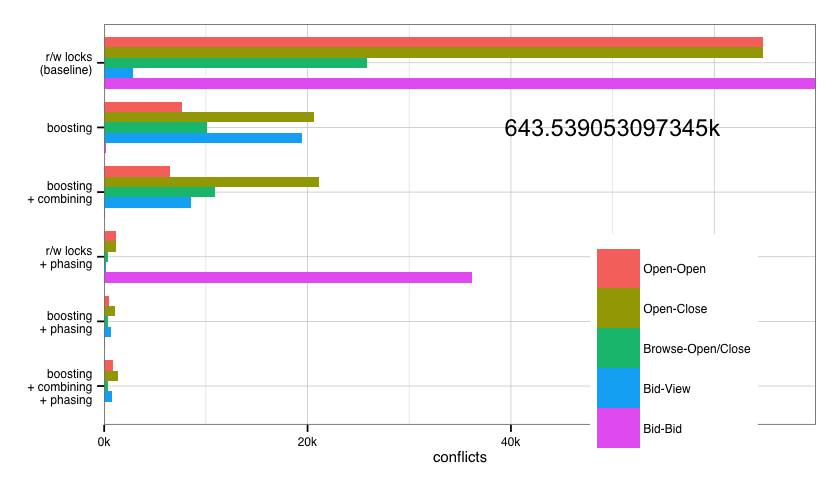

In [67]:
  ggplot(by.conflict.mean, aes(
      x = cc_ph,
      y = count,
      group = x(cc_ph,tag),
      fill = tag
  ))+
  geom_bar(stat='identity', position='dodge', width = 0.8)+
  # coord_cartesian()+
  annotate(geom='text', x = 5, y = 50000, label = (rw.count/1000)+'k')+

  ylab('conflicts')+
  coord_flip(ylim = c(0, 70000))+
  scale_y_continuous(labels = k.labels)+
  my_theme()+theme(
    axis.title.y = element_blank(),
    legend.position = c(0.8,0.2),
    legend.key.size = unit(60,'pt'),
    legend.title = element_blank()
  )

In [ ]:
j <- parse_txn_conflicts(r)
cat.yaml(j)

In [ ]:
z <- function(n) { v <- j[[n]]; if (is.null(v)) 0 else v }
l <- list(
    'Open-Open'         = z('Open'),
    'Open-Close'        = z('Open,Close') + z('Close,Open'),
    'Bid-Bid'           = z('Bid') + z('Bid,Bid'),
    'Bid-Close'         = z('Bid,Close') + z('Close,Bid'),
    'Bid-View'          = z('Bid,View') + z('View,Bid'),
    'Browse-Open/Close' = z('Browse,Close') + z('Close,Browse') +
                          z('Browse,Open') + z('Open,Browse')
)
cat.yaml(l)

In [ ]:
data.frame(tag = names(l), count = vals(l), cc_ph = r$cc_ph)

In [ ]:
cat.yaml(r)

In [ ]:
sql("SELECT cca, phasing, throughput, txn_retries FROM d WHERE nthreads = 96 and mix = 'bid-heavy' ORDER BY cca, phasing")